# Preprocessing, Step 0 bis Step 7 + Regression


In [1]:
import os
from pathlib import Path
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import missingno as msno
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [2]:
df = pd.read_csv('../../data/raw/triathlon_watch_training_data_final.csv')
# Rename columns for better handling
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.info

<bound method DataFrame.info of         id  age_of_customer     sex       ctry        town  \
0    C0001             61.0   Other         UK  Birmingham   
1    C0003             57.0   Other  Australia      Sydney   
2    C0004             30.0   Other      India   Bangalore   
3    C0005             21.0    Male    Germany      Munich   
4    C0006             63.0    Male      India      Mumbai   
..     ...              ...     ...        ...         ...   
995  C0996             28.0  Female  Australia    Brisbane   
996  C0997             54.0  Female  Australia   Melbourne   
997  C0998             35.0   Other        USA    New York   
998  C0999             31.0   Other    Germayn      Berlin   
999  C1000             27.0    Male      India      Mumbai   

     swimming_hours_per_week  biking_hours_per_week  running_hours_per_week  \
0                       2.52                   0.10                    1.78   
1                       1.55                  10.01              

In [3]:
# Spalte ID wird das führende "C" entfernt und die führenden Nullen
df["id"] = df["id"].dropna().str.replace("C", "", regex=True).astype(int)

In [4]:
# Sicherstellen, dass die Spalte als Datumsformat erkannt wird
df["most_current_software_update"] = pd.to_datetime(df["most_current_software_update"], format="%Y-%m-%d")
# ✅ Differenz zum jüngsten Datum berechnen (in Tagen)
latest_date = df["most_current_software_update"].max()
df["days_since_latest_update"] = (latest_date - df["most_current_software_update"]).dt.days
# Ergebnis ausgeben
print(df[["most_current_software_update", "days_since_latest_update"]].head())

  most_current_software_update  days_since_latest_update
0                   2024-07-22                     163.0
1                   2024-05-11                     235.0
2                   2024-08-16                     138.0
3                   2024-08-11                     143.0
4                   2024-11-18                      44.0


In [5]:
# Monat als Namen speichern (z. B. "Juli", "Mai")
df["update_month_name"] = df["most_current_software_update"].dt.strftime("%B")
# Spalte "most_current_software_update" entfernen
df = df.drop(columns=["most_current_software_update"])

In [6]:
numeric=df.select_dtypes(include=['float64']).columns.tolist() #list of numeric columns
categorical = df.select_dtypes(include=['object']).columns.to_list() #append all categorical columns to a list

In [7]:
print(df.dtypes)

id                               float64
age_of_customer                  float64
sex                               object
ctry                              object
town                              object
swimming_hours_per_week          float64
biking_hours_per_week            float64
running_hours_per_week           float64
total_training_hours_per_week    float64
vo2_max                          float64
10k_running_time_prediction      float64
calories_burned_per_week         float64
support_cases_of_customer        float64
customer_years                   float64
goal_of_training                  object
preferred_training_daytime        object
subscription_type                 object
color_of_watch                    object
synchronisation                   object
user_of_latest_model             float64
days_since_latest_update         float64
update_month_name                 object
dtype: object


**bis hierin wurde nur ganz einfache Veränderungen vollzogen. df ist nun die Grundlage für die weietren Steps**

# Step 0

In [8]:
df_step0 =df.copy()

In [9]:

target_column = "user_of_latest_model" if "user_of_latest_model" in df_step0.columns else df.columns[-1]
# Zeilen mit fehlenden Werten in der Zielvariable entfernen
df_step0 = df_step0.dropna(subset=[target_column])
# Zeilen mit mehr als zwei fehlenden Werten entfernen
df_step0 = df_step0[df_step0.isnull().sum(axis=1) <= 2]

In [10]:
# Fehlende Werte analysieren
missing_values = df_step0.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Fehlende Werte durch Durchschnitt (numerisch) oder Modus (kategorisch) ersetzen
#df_step0 = df_step0.copy()

numeric_cols = df_step0.select_dtypes(include=[np.number]).columns
categorical_cols = df_step0.select_dtypes(exclude=[np.number]).columns

for col in numeric_cols:
    df_step0[col] = df_step0[col].fillna(df_step0[col].mean())

for col in categorical_cols:
    df_step0[col] = df_step0[col].fillna(df_step0[col].mode()[0])

# Speichern der bereinigten Daten
output_path = "triathlon_watch_training_data_step0.csv"
df_step0.to_csv(output_path, index=False)

# Ergebnis anzeigen
print("Step 0 abgeschlossen. Bereinigte Daten gespeichert unter:", output_path)
print(df_step0.head())



Step 0 abgeschlossen. Bereinigte Daten gespeichert unter: triathlon_watch_training_data_step0.csv
    id  age_of_customer    sex       ctry        town  \
0  1.0             61.0  Other         UK  Birmingham   
1  3.0             57.0  Other  Australia      Sydney   
2  4.0             30.0  Other      India   Bangalore   
3  5.0             21.0   Male    Germany      Munich   
4  6.0             63.0   Male      India      Mumbai   

   swimming_hours_per_week  biking_hours_per_week  running_hours_per_week  \
0                     2.52                   0.10                    1.78   
1                     1.55                  10.01                    4.57   
2                     1.19                  12.04                    8.64   
3                     2.25                   4.67                    0.92   
4                     0.80                   5.88                    0.67   

   total_training_hours_per_week  vo2_max  ...  support_cases_of_customer  \
0                  

<Axes: >

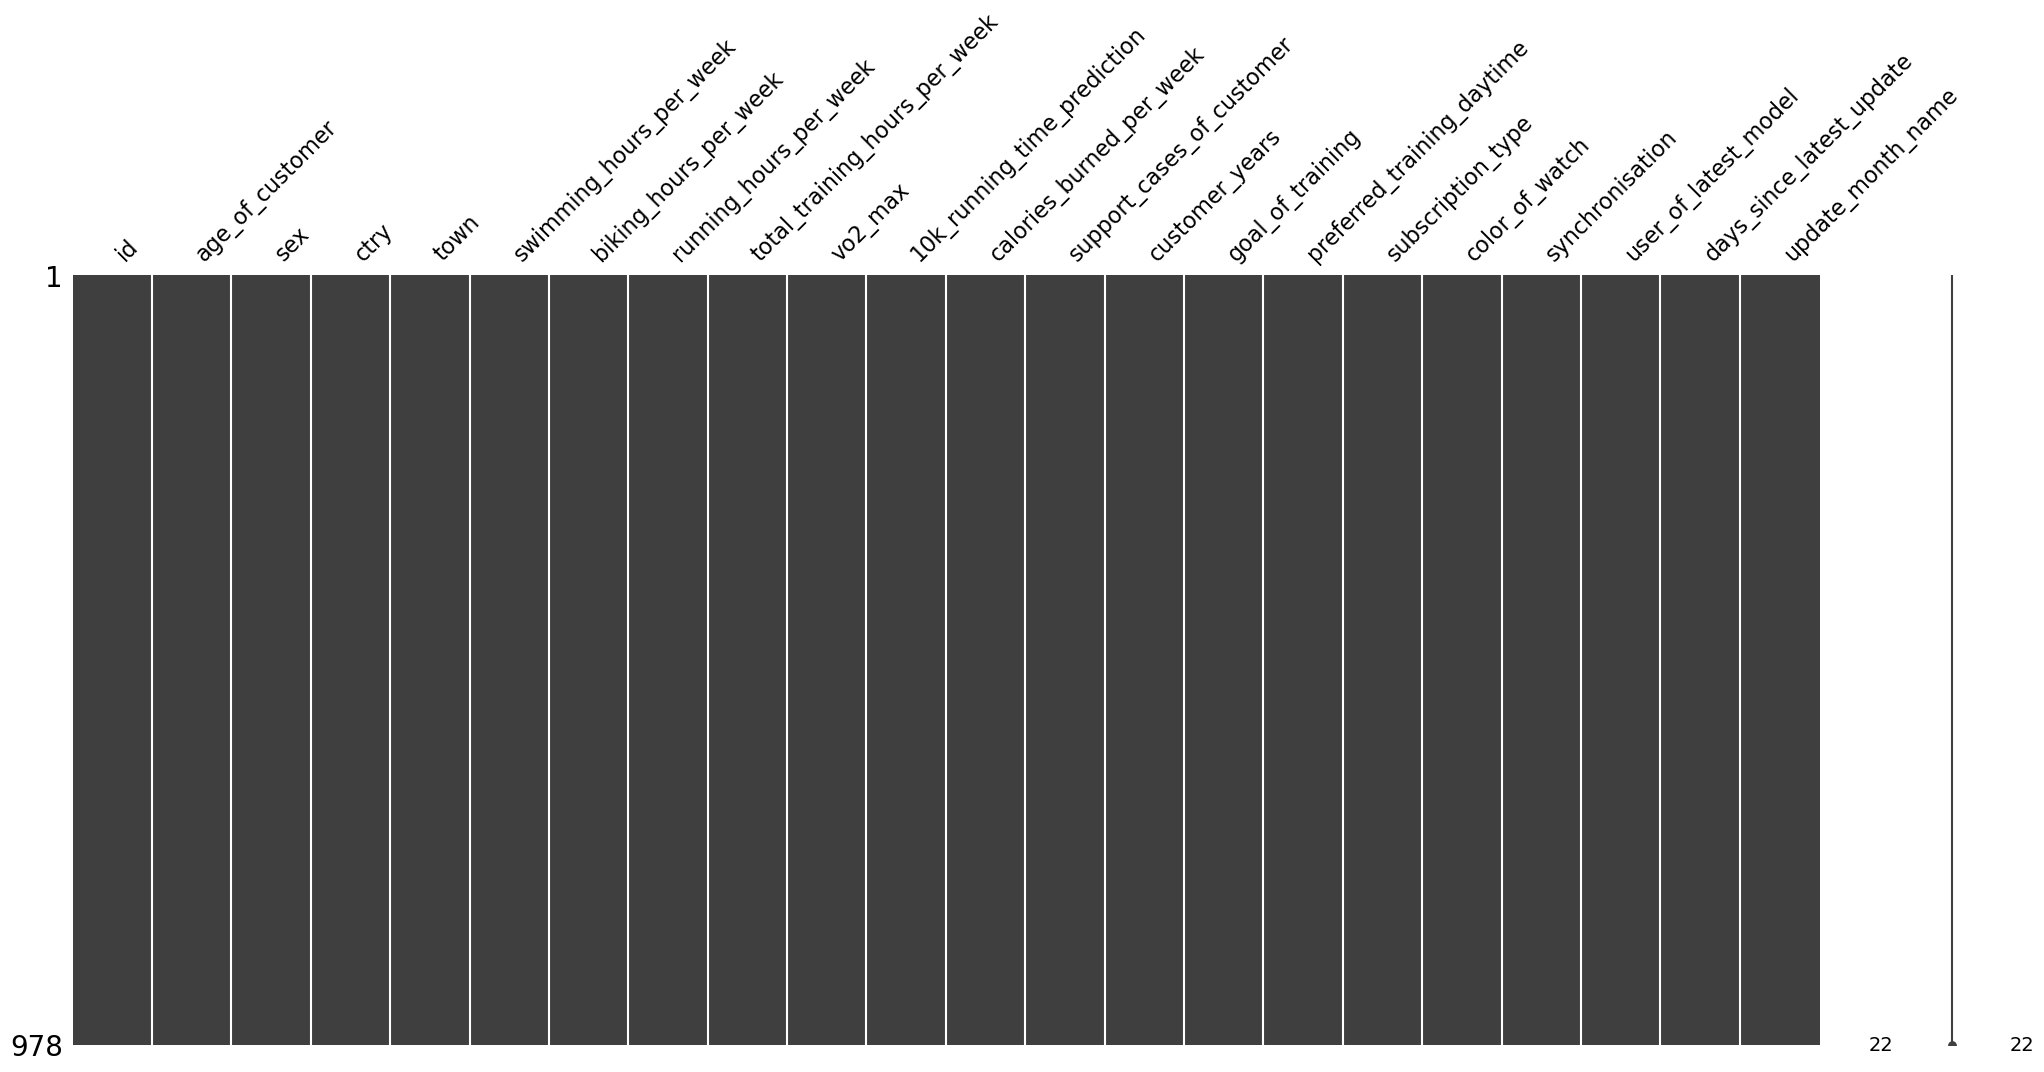

In [11]:
msno.matrix(df_step0)

In [12]:
numerical_columns = df_step0.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df_step0.select_dtypes(exclude=['number']).columns.tolist()

print("📊 Numerische Spalten:", numerical_columns)
print("🔠 Kategoriale Spalten:", categorical_columns)


📊 Numerische Spalten: ['id', 'age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week', 'support_cases_of_customer', 'customer_years', 'user_of_latest_model', 'days_since_latest_update']
🔠 Kategoriale Spalten: ['sex', 'ctry', 'town', 'goal_of_training', 'preferred_training_daytime', 'subscription_type', 'color_of_watch', 'synchronisation', 'update_month_name']


# Regression als Funktion

In [13]:
df_score = pd.DataFrame(columns=['arbeitsschritt', 'Accuracy', 'F1-Score'])

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Initialize DataFrame to store results
#df_score = pd.DataFrame(columns=['arbeitsschritt', 'Accuracy', 'F1-Score'])


def run_logistic_regression(df, arbeitsschritt):
    global df_score
    # Trennen von Features und Zielvariable
    target_column = 'user_of_latest_model'
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identifikation der kategorischen Variablen
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # One-Hot-Encoding für kategoriale Variablen
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_encoded = pd.DataFrame(
        encoder.fit_transform(X[categorical_cols]),
        columns=encoder.get_feature_names_out(categorical_cols),
        index=X.index
    )

    # Numerische Spalten beibehalten
    X_numeric = X.drop(columns=categorical_cols)

    # Zusammenfügen der numerischen und encodierten Daten
    X_final = pd.concat([X_numeric, X_encoded], axis=1)
    
    # Aufteilen in Trainings- und Testset
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

    model = LogisticRegression(
        solver='liblinear',   # Guter Standard für kleine/mittelgroße Daten
        #solver='lbfgs' ,       # ebenfalls für kleine Daten
        #penalty='l2',         # Feature-Selektion, wenn auskommentiert wird automatisch l2 genommen
        #C=0.5,                # Moderate Regularisierung
        #class_weight='balanced', # Falls die Klassen unausgeglichen sind
        max_iter=500,         # Erhöhte Iterationen für Stabilität
        random_state=42       # Reproduzierbarkeit
    )
    model.fit(X_train, y_train)

    # Vorhersagen
    y_pred = model.predict(X_test)

    # Metriken berechnen
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}")
    
    # Neue Zeile zur bestehenden DataFrame hinzufügen
    new_row = pd.DataFrame({
        "arbeitsschritt": [arbeitsschritt],
        "Accuracy": [accuracy],
        "F1-Score": [f1]
    })
    df_score = pd.concat([df_score, new_row], ignore_index=True)

    return model, df_score



In [15]:
run_logistic_regression(df_step0, 'step 0')
df_score

Accuracy: 0.77, F1-Score: 0.71


C:\Users\laukat\AppData\Local\Temp\ipykernel_63780\3526106794.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_score = pd.concat([df_score, new_row], ignore_index=True)


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677


<Axes: >

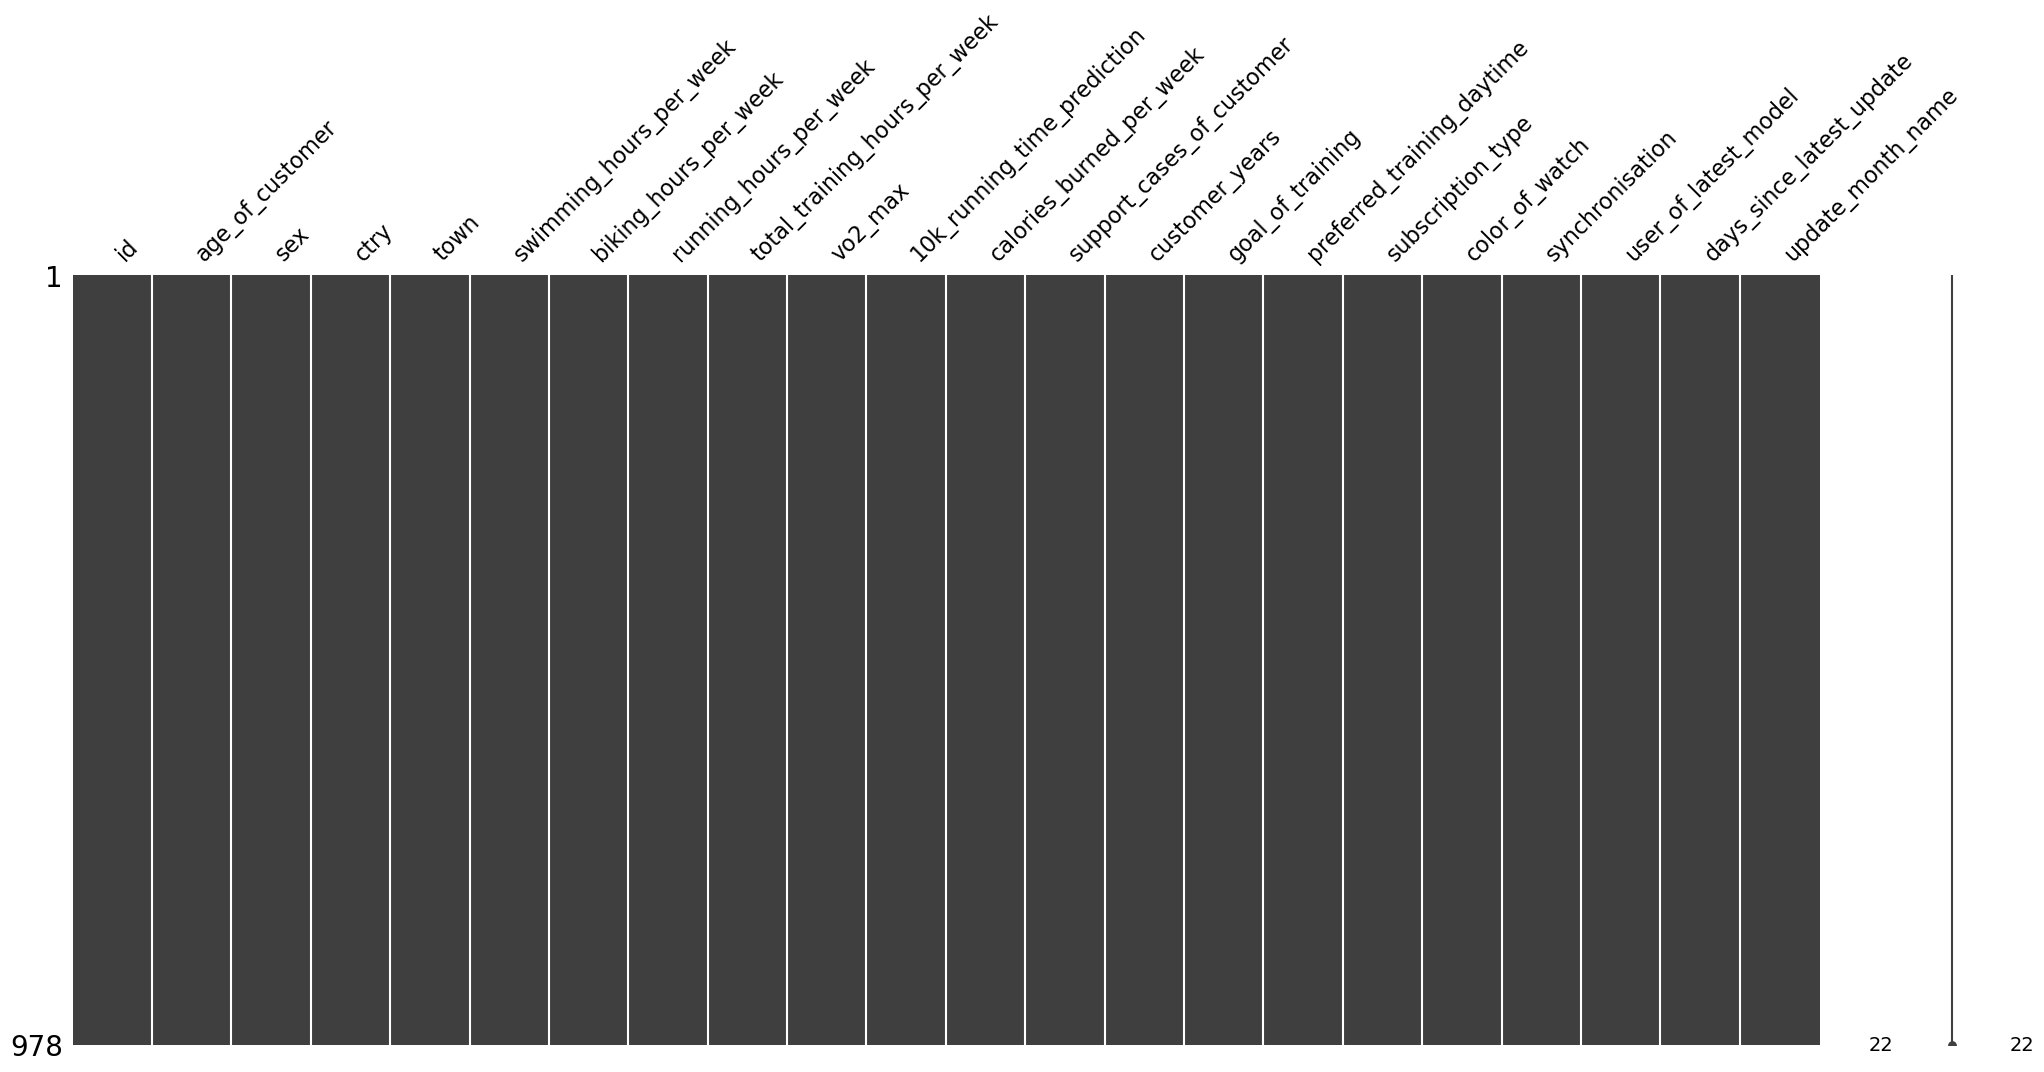

In [16]:
msno.matrix(df_step0)

# Step 1 

In [17]:
df_step1 = df_step0.copy()

In [18]:
# Überblick über das Feature "ctry"
ctry_overview = df_step1['ctry'].value_counts()
# Ergebnis anzeigen
print(ctry_overview)

# Korrigiere den Ländernamen "Germayn" zu "Germany"
df_step1['ctry'] = df_step1['ctry'].replace('Germayn', 'Germany')

# Überprüfen, ob die Änderung erfolgreich war
ctry_overview = df_step1['ctry'].value_counts()
print(ctry_overview)

ctry
Australia      200
USA            199
UK             191
India          186
Germany        179
Germayn         19
UnknownLand      4
Name: count, dtype: int64
ctry
Australia      200
USA            199
Germany        198
UK             191
India          186
UnknownLand      4
Name: count, dtype: int64


In [19]:
# Doppelte Datensätze anzeigen
duplicate_rows = df_step1[df_step1.duplicated()]
print("Doppelte Datensätze:")
print(duplicate_rows)

# Doppelte Datensätze entfernen
df_step1 = df_step1.drop_duplicates()
print("Doppelte Datensätze wurden entfernt.")

Doppelte Datensätze:
        id  age_of_customer    sex       ctry        town  \
642  640.0             29.0  Other  Australia   Melbourne   
714  708.0             55.0  Other         UK  Birmingham   

     swimming_hours_per_week  biking_hours_per_week  running_hours_per_week  \
642                     5.06                   1.44                    0.25   
714                     0.40                   5.89                    2.07   

     total_training_hours_per_week  vo2_max  ...  support_cases_of_customer  \
642                           6.75    54.86  ...                        0.0   
714                           8.37    40.73  ...                        0.0   

     customer_years  goal_of_training  preferred_training_daytime  \
642             3.0           Fitness                     Evening   
714             7.0        Recreation                     Morning   

    subscription_type color_of_watch synchronisation user_of_latest_model  \
642             Basic          Bla

In [20]:
run_logistic_regression(df_step1, 'step 1')
df_score

Accuracy: 0.76, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656


<Axes: >

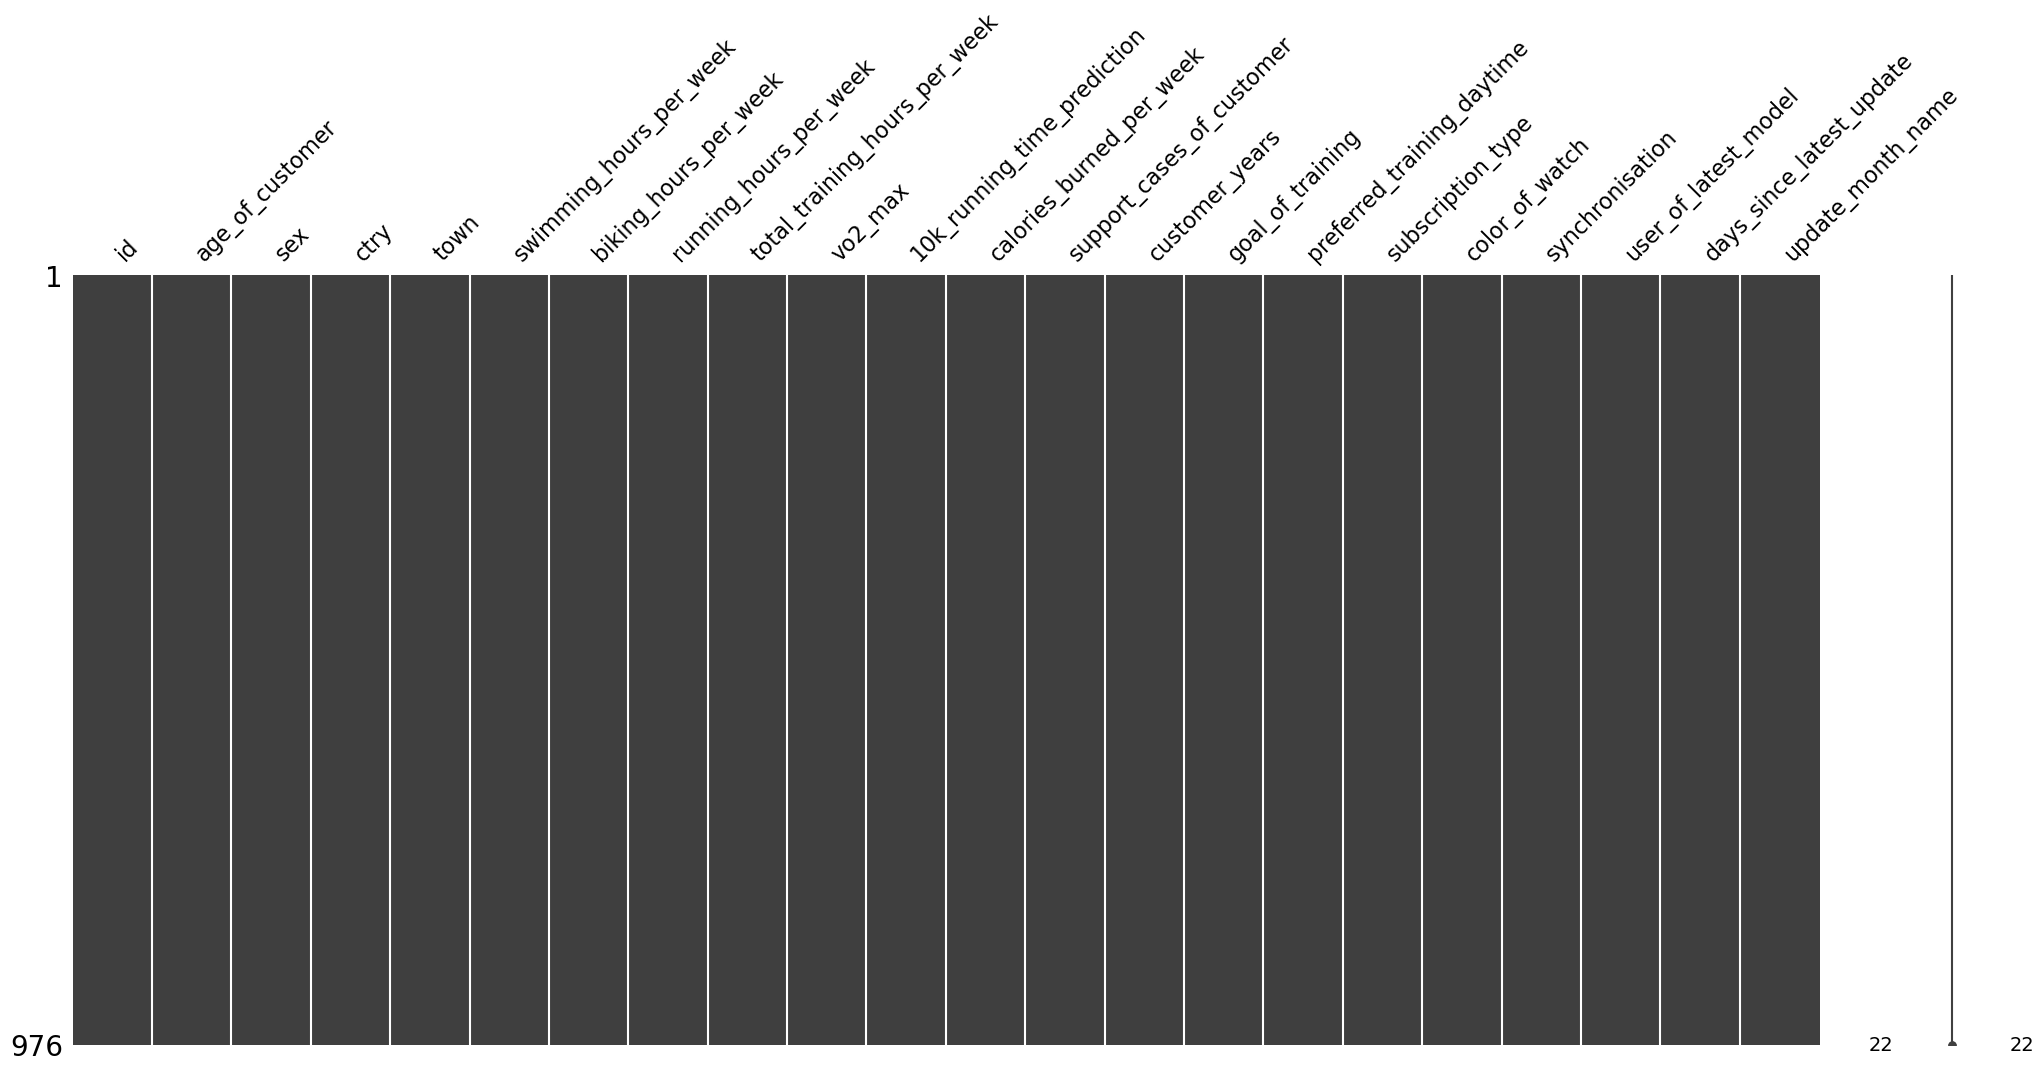

In [21]:
msno.matrix(df_step1)


# Step 2

In [22]:
df_step2 = df.copy()

<Axes: >

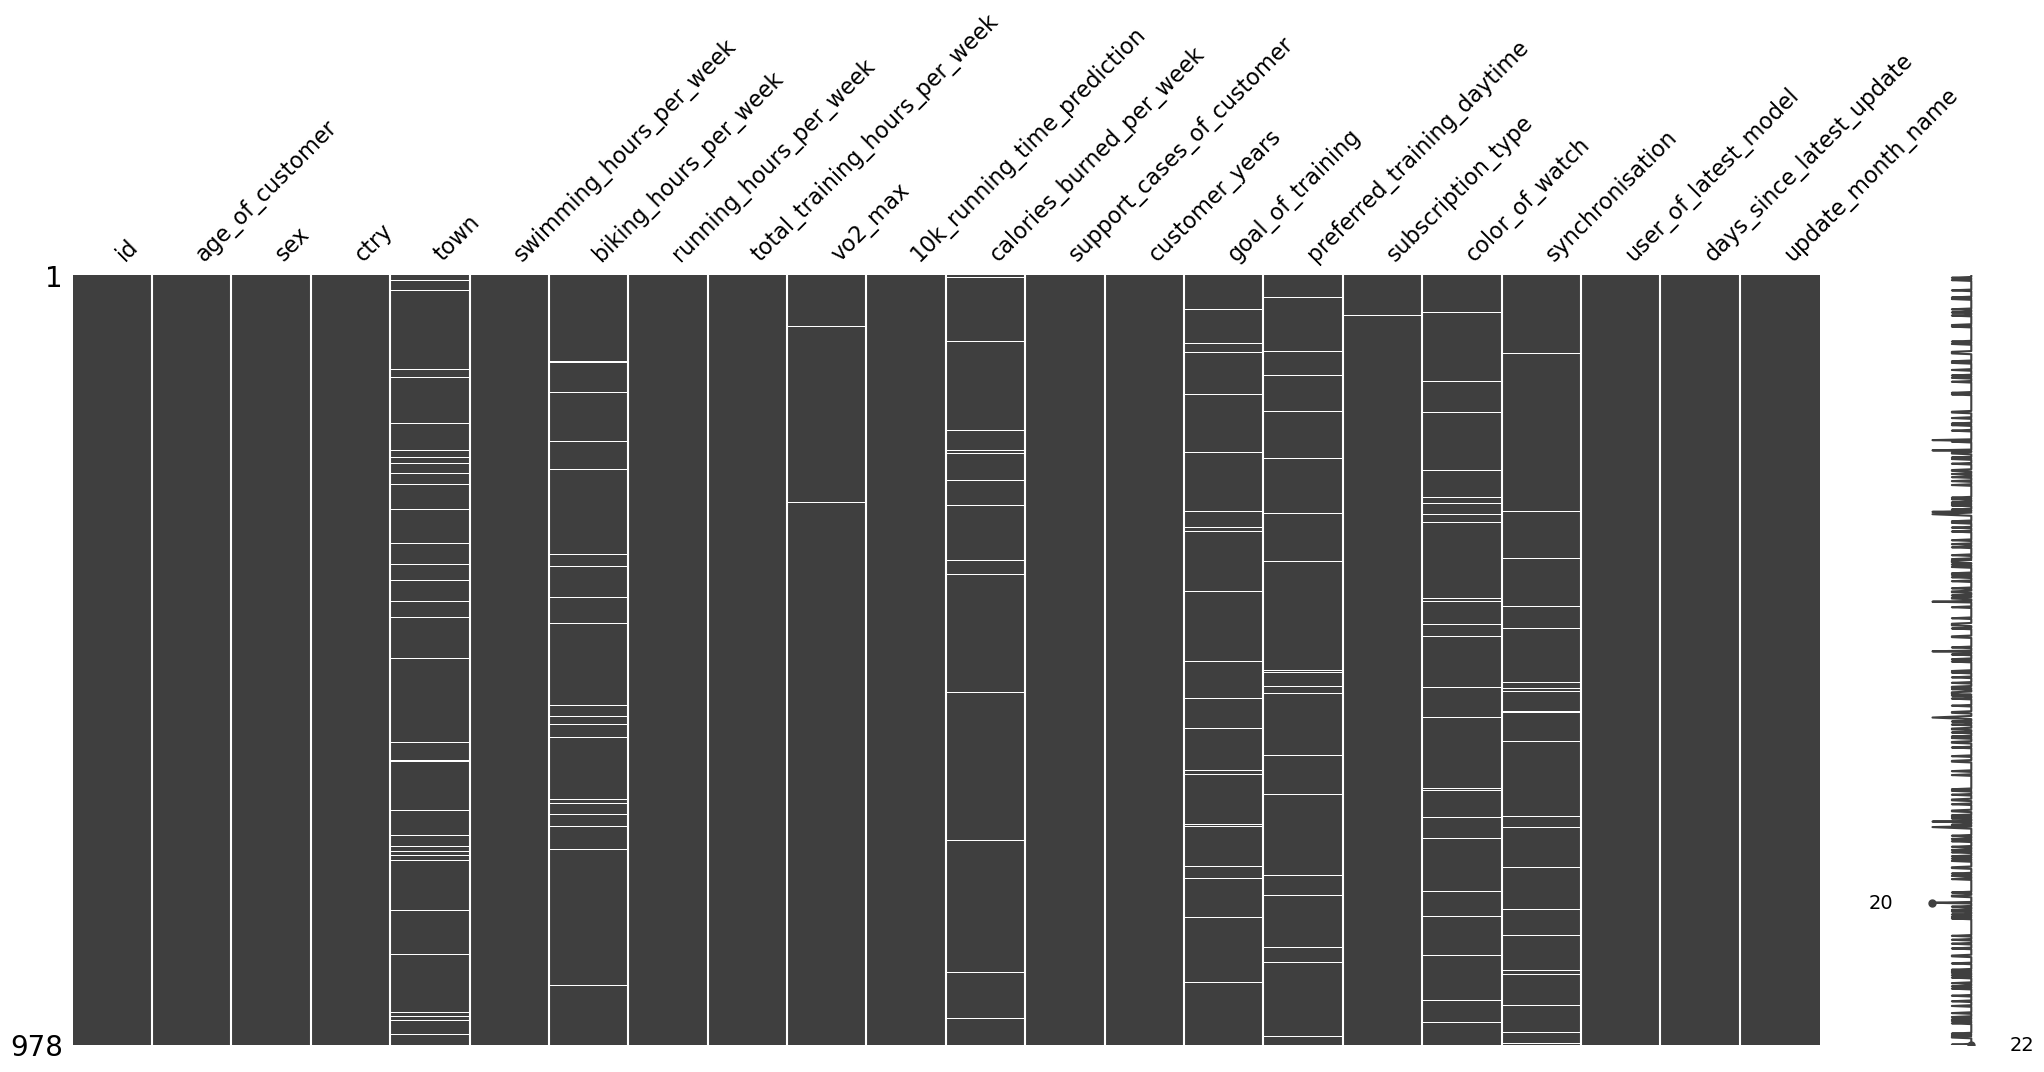

In [23]:
#Listwise deletion all rows with missing values in the column 'user_of_latest_model'
df_step2=df_step2.drop(df_step2[df_step2['user_of_latest_model'].isnull()].index)
msno.matrix(df_step2)

In [24]:
df_step2[numeric].isnull().sum()

id                                0
age_of_customer                   0
swimming_hours_per_week           0
biking_hours_per_week            24
running_hours_per_week            0
total_training_hours_per_week     0
vo2_max                           4
10k_running_time_prediction       0
calories_burned_per_week         19
support_cases_of_customer         0
customer_years                    0
user_of_latest_model              0
days_since_latest_update          1
dtype: int64

In [25]:
correlation_with_A = df_step2[numeric].corr()['biking_hours_per_week'].drop('biking_hours_per_week')  # Entferne die Korrelation mit sich selbst

# Ausgabe der Korrelation
print(correlation_with_A)

id                              -0.023415
age_of_customer                  0.001405
swimming_hours_per_week          0.133546
running_hours_per_week           0.162726
total_training_hours_per_week    0.530162
vo2_max                          0.164993
10k_running_time_prediction     -0.159664
calories_burned_per_week         0.804664
support_cases_of_customer        0.030294
customer_years                   0.008436
user_of_latest_model             0.228377
days_since_latest_update        -0.014664
Name: biking_hours_per_week, dtype: float64


In [26]:
#  Iterative Imputation for numeric columns
imputer = IterativeImputer(max_iter=30, tol=1e-2, random_state=42, initial_strategy='median') #initial all missing values were replaced by median
df_step2_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_step2[numeric])) # creating a new dataframe with imputed values

df_step2_numeric_imputed.index = df_step2.index # adapt index of new dataframe to index of original dataframe
df_step2[numeric] = df_step2_numeric_imputed # replace numeric columns in original dataframe with imputed values

print(df_step2[numeric].isnull().sum()) # check if all missing values in numeric columns were imputed

id                               0
age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
user_of_latest_model             0
days_since_latest_update         0
dtype: int64


In [27]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# 1. Kategorische Spalten in numerische Werte umwandeln
label_encoders = {}  # Dictionary, um die LabelEncoder zu speichern

for col in categorical:
    if df_step2[col].dtype == 'object':  # Überprüfen, ob es sich um eine kategorische Spalte handelt
        encoder = LabelEncoder()
        df_step2[col] = encoder.fit_transform(df_step2[col].fillna('Missing'))  # Umwandlung und fehlende Werte ersetzen
        label_encoders[col] = encoder  # Speichern des Encoders

# 2. KNN-Imputation auf den numerischen Werten anwenden
imputer = KNNImputer(n_neighbors=2)  # Anzahl der Nachbarn (k) einstellen
df_imputed_categorical = pd.DataFrame(imputer.fit_transform(df_step2[categorical]), columns=categorical)

# 3. Imputierte Werte zurück in kategorische Werte umwandeln
for col, encoder in label_encoders.items():
    df_imputed_categorical[col] = encoder.inverse_transform(df_imputed_categorical[col].round().astype(int))  # Rückumwandlung

# Ausgabe des imputierten DataFrames
df_imputed_categorical

df_imputed_categorical.index = df_step2.index # adapt index of new dataframe to index of original dataframe
df_step2[categorical] = df_imputed_categorical # replace numeric columns in original dataframe with imputed values

print(df_step2.isnull().sum()) # check if all missing values in numeric columns were imputed

id                               0
age_of_customer                  0
sex                              0
ctry                             0
town                             0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
goal_of_training                 0
preferred_training_daytime       0
subscription_type                0
color_of_watch                   0
synchronisation                  0
user_of_latest_model             0
days_since_latest_update         0
update_month_name                0
dtype: int64


In [28]:
run_logistic_regression(df_step2, 'step 2')
df_score

Accuracy: 0.77, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882


# Step 3

In [29]:
df_step3 = df_step0.copy()

#  Detection of outliers with IQR-method
def detect_outliers_iqr(df):
    df_outliers = df.copy()
    for col in df.select_dtypes(include=np.number):  # Nur numerische Spalten
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[col] = df[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
    return df_outliers


#  Replacement of outliers mit NaN
data_numeric_no_outliers = detect_outliers_iqr(df_step3[numeric])

data_numeric_no_outliers.isnull().sum()

id                                0
age_of_customer                   0
swimming_hours_per_week          13
biking_hours_per_week             7
running_hours_per_week           12
total_training_hours_per_week    13
vo2_max                          18
10k_running_time_prediction      12
calories_burned_per_week         12
support_cases_of_customer         0
customer_years                    0
user_of_latest_model              0
days_since_latest_update          0
dtype: int64

In [30]:
#  Iterative Imputation for numeric columns
imputer = IterativeImputer(max_iter=30, tol=1e-2, random_state=42, initial_strategy='median') #initial all missing values were replaced by median
data_numeric_imputed = pd.DataFrame(imputer.fit_transform(data_numeric_no_outliers)) # creating a new dataframe with imputed values

data_numeric_imputed.index = df_step3.index # adapt index of new dataframe to index of original dataframe
#df_imputed_numeric = df_step3.copy() # create a copy of the original dataframe
df_step3[numeric] = data_numeric_imputed # replace numeric columns in original dataframe with imputed values

print(df_step3[numeric].isnull().sum()) # check if all missing values in numeric columns were imputed

id                               0
age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
user_of_latest_model             0
days_since_latest_update         0
dtype: int64


In [32]:
run_logistic_regression(df_step3, 'step 3')
df_score

Accuracy: 0.77, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677


# Step 4